In [76]:
import numpy as np

from scorta.recsys.candidate_generate import CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
import polars as pl

from hydra import initialize, compose
from scorta.utils.utils import seed_everything

from scorta.feature.feature import FeatureMerger
from atma_16.feature.feature import YadoRawFeature, YadoRankFeature, SessionFeature

In [77]:
seed_everything()

exp_name = "004_add_discussion_candidates"
input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

feature_dir = input_dir / "feature"
feature_dir.mkdir(exist_ok=True)

output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)


with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")
    print(cfg.feature)

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()

yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

{'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], 'key_cols': ['yad_no']}, 'Session': {'feature_cols': ['user_mode_wid_cd', 'user_mode_ken_cd', 'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg', 'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min', 'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5min'], 'key_cols': ['session_id']}, 'YadoRank': {'feature_cols': ['yad_cnt', 'yad_cnt_rank', 'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd', 'yad_cnt_rank_sml_cd'], 'key_cols': ['yad_no']}}


In [78]:
train_log = dl.load_train_log()
label = dl.load_train_label()
test_log = dl.load_train_log()

In [79]:
from atma_16.candidate.candidate import (
    LastSeenedCandidate,
    PopularAtCDCandidate,
    # TopBookedFromLastViewCandidate,
    CoVisitCandidate,
)

train_candidates = [
    CoVisitCandidate(dl, candidate_dir, target_df=target_df),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, target_df=target_df),
    LastSeenedCandidate(dl, candidate_dir, target_df=target_df),
    PopularAtCDCandidate(dl, candidate_dir, target_df=target_df),
]
test_candidates = [
    CoVisitCandidate(dl, candidate_dir, mode="test"),
    # TopBookedFromLastViewCandidate(dl, candidate_dir, mode="test"),
    LastSeenedCandidate(dl, candidate_dir, mode="test"),
    PopularAtCDCandidate(dl, candidate_dir, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}


for mode, candidates in cands_dic.items():
    print(mode)
    for cand in candidates:
        df = cand.generate()
        cand.save(df)
        print(cand.evaluator.evaluate(df, cand.class_name))

    cm = CandidateMerger(
        dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
    )
    merged_df = cm.merge()
    cm.save(merged_df)

train
{1: {'eval_time': '2023/12/13/11:38:01', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 288698, 'unique_user_cnt': 288698, 'unique_item_cnt': 7110, 'eval_dic': {1: {'precision@1': 0.071763573007087, 'recall@1': 0.071763573007087, 'f1@1': 0.071763573007087}}}, 5: {'eval_time': '2023/12/13/11:38:01', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 1374128, 'unique_user_cnt': 288698, 'unique_item_cnt': 10719, 'eval_dic': {1: {'precision@5': 0.05867502881827603, 'recall@5': 0.2792779998475916, 'f1@5': 0.09697587119758773}}}, 10: {'eval_time': '2023/12/13/11:38:02', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 2564831, 'unique_user_cnt': 288698, 'unique_item_cnt': 11510, 'eval_dic': {1: {'precision@10': 0.04803591347734022, 'recall@10': 0.4267573727563059, 'f1@10': 0.08635202235547632}}}, 50: {'eval_time': '2023/12/13/11:38:02', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 6305242, 'unique_user_cnt': 288698, 'unique_item_cnt': 11882, 'eval_dic': {1: {'precision@50': 0.030506362800983688, 'recall@5

3it [00:01,  2.63it/s]


test
{1: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 174700, 'unique_user_cnt': 174700, 'unique_item_cnt': 6505, 'eval_dic': {}}, 5: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 835507, 'unique_user_cnt': 174700, 'unique_item_cnt': 10383, 'eval_dic': {}}, 10: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 1549092, 'unique_user_cnt': 174700, 'unique_item_cnt': 11242, 'eval_dic': {}}, 50: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 3501429, 'unique_user_cnt': 174700, 'unique_item_cnt': 11683, 'eval_dic': {}}, 100: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'CoVisitCandidate', 'pair_cnt': 3676610, 'unique_user_cnt': 174700, 'unique_item_cnt': 11688, 'eval_dic': {}}}
{1: {'eval_time': '2023/12/13/11:38:10', 'cg_name': 'LastSeenedCandidate', 'pair_cnt': 60760, 'unique_user_cnt': 60760, 'unique_item_cnt': 8000, 'eval_dic': {}}, 5: {'eval_time': '202

3it [00:00,  4.78it/s]


In [90]:
train_df = CandidateMerger(dl, train_candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, test_candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

In [91]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name=f"{exp_name}.yaml")

train_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.Session),
]

test_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.Session),
]


feats_dic = {
    "train": {
        "df": train_df,
        "feats": train_feats,
    },
    "test": {
        "df": test_df,
        "feats": test_feats,
    },
}
merged_df_dic = {}

for mode, obj in feats_dic.items():
    for feat in obj["feats"]:
        df = feat.fit(obj["df"])
        feat.save(df)

    fm = FeatureMerger(output_dir=feature_dir, features=obj["feats"], mode=mode)
    merged_df = fm.merge(obj["df"])
    fm.save(merged_df)
    merged_df_dic[mode] = merged_df

(13372, 11)


100%|██████████| 3/3 [00:00<00:00, 13.01it/s]

YadoRawFeature (7758614, 25)
YadoRankFeature_train (7758614, 31)
SessionFeature_train (7758614, 42)


(11223, 11)


100%|██████████| 3/3 [00:00<00:00, 17.82it/s]


YadoRawFeature (4265446, 23)
YadoRankFeature_test (4265446, 29)
SessionFeature_test (4265446, 40)


In [92]:
X_train = merged_df_dic["train"].drop(["fold", "label"])
y_train = merged_df_dic["train"]["label"]

In [93]:
from typing import Iterator, Any
import pandas as pd


class ColumnBasedCV:
    def __init__(self, dl: AtmaData16Loader):
        self.label = dl.load_train_label()

    def split(self, X: pd.DataFrame, y: Any) -> Iterator[tuple[np.array, np.array]]:
        for fold in range(5):
            idx_pair = (
                pl.DataFrame(X).join(self.label, on=["session_id"], how="left").with_row_count()[["row_nr", "fold"]]
            )

            train_idx = idx_pair.filter(pl.col("fold") != fold)["row_nr"].to_numpy()
            test_idx = idx_pair.filter(pl.col("fold") == fold)["row_nr"].to_numpy()
            yield train_idx, test_idx


cv = ColumnBasedCV(dl)

In [94]:
sorted(X_train.columns)

['CoVisitCandidate_rank',
 'CoVisitCandidate_score',
 'LastSeenedCandidate_rank',
 'LastSeenedCandidate_score',
 'PopularAtCDCandidate_rank',
 'PopularAtCDCandidate_score',
 'cand_selected_cnt',
 'kd_bch_5min',
 'kd_conv_walk_5min',
 'kd_slp_5min',
 'kd_stn_5min',
 'ken_cd',
 'lrg_cd',
 'onsen_flg',
 'rank',
 'session_id',
 'sml_cd',
 'sum_score',
 'total_room_cnt',
 'user_mean_kd_bch_5min',
 'user_mean_kd_conv_walk_5min',
 'user_mean_kd_slp_5min',
 'user_mean_kd_stn_5min',
 'user_mean_onsen_flg',
 'user_mean_total_room_cnt',
 'user_mean_wireless_lan_flg',
 'user_mode_ken_cd',
 'user_mode_lrg_cd',
 'user_mode_sml_cd',
 'user_mode_wid_cd',
 'wid_cd',
 'wireless_lan_flg',
 'yad_cnt',
 'yad_cnt_rank',
 'yad_cnt_rank_ken_cd',
 'yad_cnt_rank_lrg_cd',
 'yad_cnt_rank_sml_cd',
 'yad_cnt_rank_wid_cd',
 'yad_no',
 'yad_type']

In [95]:
cat_params = {
    "iterations": 1000,
    "depth": 5,
    "loss_function": "Logloss",
    "random_seed": 42,
    "early_stopping_rounds": 50,
}

from scorta.model.gradient_boost import GBTWrapper

gbdt = GBTWrapper("cat", "bin")
models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=cat_params, cv=cv)

Learning rate set to 0.273983
0:	learn: 0.3030516	test: 0.3031020	best: 0.3031020 (0)	total: 705ms	remaining: 11m 44s
1:	learn: 0.1690760	test: 0.1692385	best: 0.1692385 (1)	total: 965ms	remaining: 8m 1s
2:	learn: 0.1187098	test: 0.1189509	best: 0.1189509 (2)	total: 1.3s	remaining: 7m 12s
3:	learn: 0.1006284	test: 0.1009217	best: 0.1009217 (3)	total: 1.71s	remaining: 7m 5s
4:	learn: 0.0926663	test: 0.0929747	best: 0.0929747 (4)	total: 2.01s	remaining: 6m 40s
5:	learn: 0.0892159	test: 0.0895420	best: 0.0895420 (5)	total: 2.27s	remaining: 6m 15s
6:	learn: 0.0862875	test: 0.0866351	best: 0.0866351 (6)	total: 2.57s	remaining: 6m 4s
7:	learn: 0.0852556	test: 0.0856145	best: 0.0856145 (7)	total: 2.87s	remaining: 5m 56s
8:	learn: 0.0841684	test: 0.0845447	best: 0.0845447 (8)	total: 3.2s	remaining: 5m 52s
9:	learn: 0.0837220	test: 0.0840993	best: 0.0840993 (9)	total: 3.51s	remaining: 5m 47s
10:	learn: 0.0831410	test: 0.0835377	best: 0.0835377 (10)	total: 3.91s	remaining: 5m 51s
11:	learn: 0.08

In [52]:
train_df = merged_df_dic["train"]
test_df = merged_df_dic["test"]

In [74]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

0.3980568602637159


/Users/zerebom/ghq/github.com/zerebom/scorta/scorta/eda/df.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, y="column", x="feature_importance", order=order, ax=ax, palette="viridis")


(<Figure size 1200x820 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

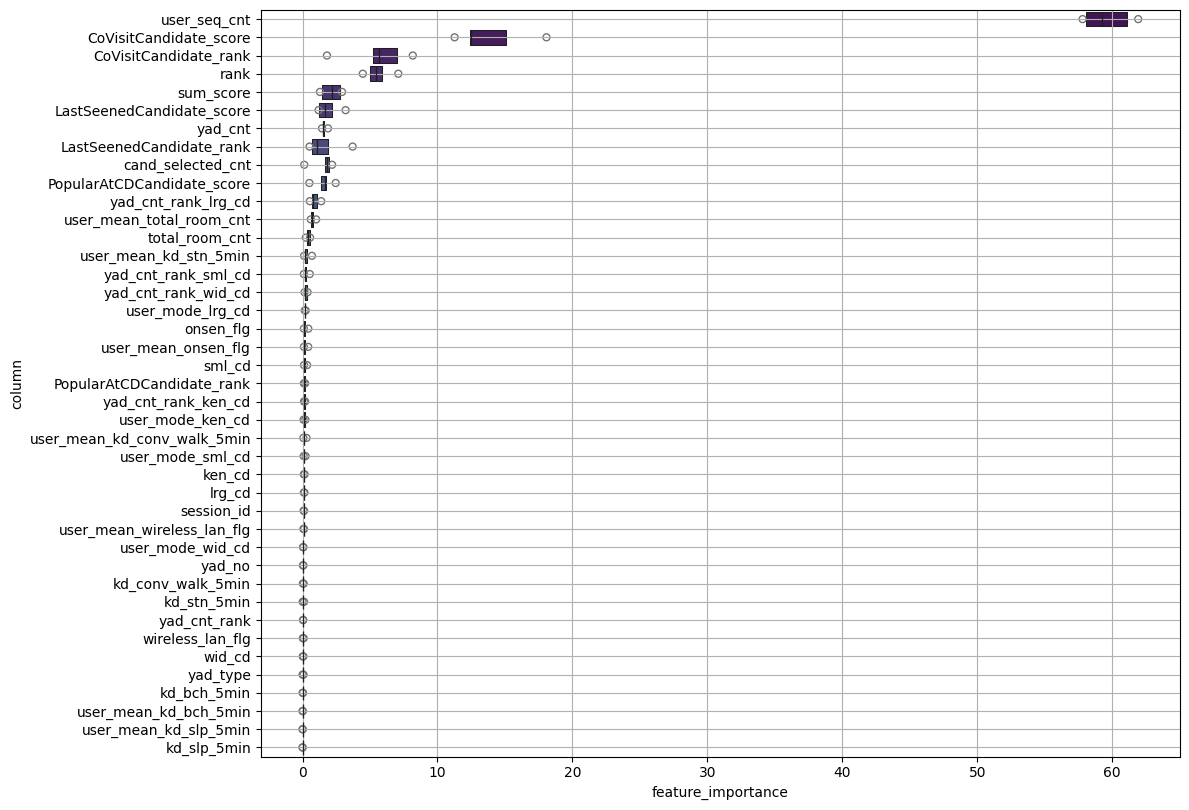

In [75]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(gbdt.feature_importance(), X_train.to_pandas())

In [16]:
test_pdf

NameError: name 'test_pdf' is not defined

In [57]:
test_pdf = test_df.to_pandas()

In [58]:
import numpy as np

preds = np.array([gbdt.predict(test_pdf, i) for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

<Axes: ylabel='Count'>

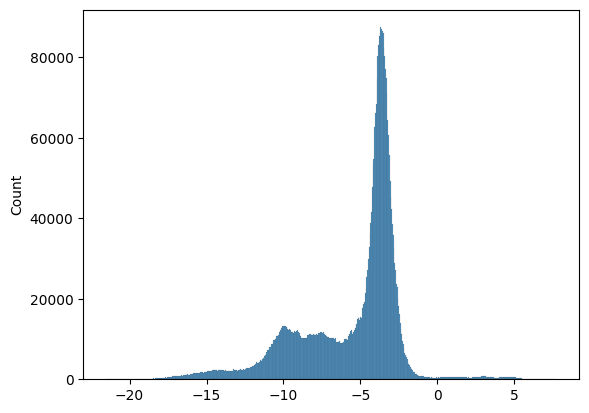

In [59]:
import seaborn as sns

sns.histplot(preds)

<Axes: ylabel='Count'>

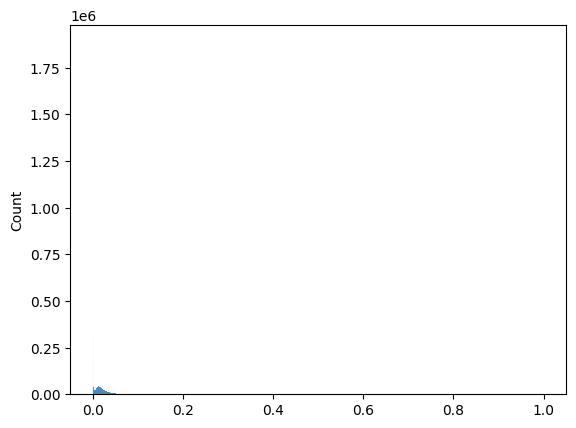

In [60]:
sns.histplot(oof[:, 1])

In [25]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [26]:
# (sub.with_columns(
#     pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
# )
# .sort(["session_id", "rank"])
# .filter(pl.col("rank") <= 9)
# .group_by("session_id", maintain_order=True)
# .agg("yad_no"))

In [27]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [28]:
np.array(fill_sub_lists).shape

(174700, 10)

In [29]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}_add_feat.csv", index=False)